In [29]:
# Importing necessary packages
import os                                                 # set current working directory 
import sys                                                # enable/disable some outputs for clarity
import numpy as np                                        # arrays and matrix math
import pandas as pd                                       # DataFrames
import matplotlib.pyplot as plt                           # plotting
import geostatspy.geostats as geostats                    # synthetic data generation using Sequential Gaussian Simulation
import geostatspy.GSLIB as GSLIB                          # synthetic data generation using Sequential Gaussian Simulation
import random                                             # random number generation

from sklearn.preprocessing import StandardScaler          # standard normalization of data
from IPython.display import clear_output

%matplotlib inline
cmap = plt.cm.inferno                                     # color map

In [31]:
# Disable printing
def blockPrint():
    sys.stdout = open(os.devnull, 'w')

# Enable Printing
def enablePrint():
    sys.stdout = sys.__stdout__

# Benchmark generator subroutine. Uses SGSIM and cokriging to generate multi-feature simulations.
def benchmark_generator(corrs, df, hmaj, hmin, num_of_features, seed, x_str='X', y_str='Y', feature_str='Porosity'):
    '''Benchmark data generator. Generates num_of_features amount of features. Consequently, corrs array should be the same size
    and the first element should be 0
    '''
    x, y = np.indices((100,100))
    x = x.flatten()
    y = y.flatten()
    dataframe = pd.DataFrame({'x':x, 'y':y})
    krig_arr = [0] + [4 for n in range(num_of_features-1)] # we need the first ktype to be 0 (regular kriging) and the rest to be 4 (cokriging)
    sec_first = 0
    sims = []
    for i in range(num_of_features):
        vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=hmaj,hmin1=hmin)
        sim_sk = geostats.sgsim(df,x_str,y_str,feature_str,wcol=-1,scol=-1,tmin=tmin,tmax=tmax,itrans=1,ismooth=0,dftrans=0,tcol=0,
            twtcol=0,zmin=0.0,zmax=0.3,ltail=1,ltpar=0.0,utail=1,utpar=0.3,nsim=1,
            nx=nx,xmn=xmn,xsiz=xsiz,ny=ny,ymn=ymn,ysiz=ysiz,seed=seed+i,
            ndmin=ndmin,ndmax=ndmax,nodmax=20,mults=1,nmult=3,noct=-1,radius=radius,radius1=100000,sang1=0,
            mxctx=81,mxcty=81,ktype=krig_arr[i],colocorr=corrs[i],sec_map=sec_first,vario=vario)
        sim_sk = GSLIB.affine(sim_sk,0.0,1.0) # correct the mean and variance
        sims.append(sim_sk)
        sim_flat = sim_sk.flatten()
        dataframe['feature' + str(i)] = sim_flat
        if(i==0):
            sec_first = sim_sk
    
    return sims, dataframe

# Variogram plot subroutine
def vargplot(feature,lags,gamma_maj,gamma_min,npps_maj,npps_min,vmodel,azi,atol,sill, save=None):     # plot the variogram
    index_maj,lags_maj,gmod_maj,cov_maj,ro_maj = geostats.vmodel(nlag=100,xlag=10,azm=azi,vario=vmodel);
    index_min,lags_min,gmod_min,cov_min,ro_min = geostats.vmodel(nlag=100,xlag=10,azm=azi+90.0,vario=vmodel);
    
    plt.scatter(lags,gamma_maj,color = 'black',s = npps_maj*0.01,label = 'Major Azimuth ' +str(azi), alpha = 0.8)
    #plt.plot(lags_maj,gmod_maj,color = 'black')
    plt.scatter(lags,gamma_min,color = 'red',s = npps_min*0.01,label = 'Minor Azimuth ' +str(azi+90.0), alpha = 0.8)
    #plt.plot(lags_min,gmod_min,color = 'red')
    plt.plot([0,2000],[sill,sill],color = 'black')
    plt.xlabel(r'Lag Distance $\bf(h)$, (m)')
    plt.ylabel(r'$\gamma \bf(h)$')
    if atol < 90.0:
        plt.title('Directional ' + feature + ' Variogram')
    else: 
        plt.title('Omni Directional NSCORE ' + feature + ' Variogram')
    plt.xlim([0,10000]); #plt.ylim([0,1.8])
    plt.legend(loc="lower right")
    plt.grid(visible=True, which='major', color='black', linestyle='-')
    plt.grid(visible=True, which='minor', color='gray', linestyle='--')
    plt.minorticks_on()
    if(save!=None):
        plt.savefig(save + '.png')

In [12]:
# Taking one point from an existing dataset to create our realizations.
# This way, we are in a way building 'unconditional simulations'
seed = 73703 # Setting a random seed
df_orig = pd.read_csv(r"https://raw.githubusercontent.com/GeostatsGuy/GeoDataSets/master/sample_data_MV_biased.csv") # from Dr. Pyrcz's GitHub repo
df_orig = df_orig.sample(50, random_state=seed)                     # extract 50 samples
df_orig = df_orig.reset_index()                                     # reset the record index 
df_orig = df_orig.drop(['index','Unnamed: 0'],axis=1)               # remove extra columns in DataFrame
df_orig['logPerm'] = np.log(df_orig['Perm'].values)                 # calculate the log of permeability
#df_orig['X'] = df_orig['X'] + 9999999.9
df_orig = df_orig.iloc[:1]
df_orig.iloc[0,0] = 500.0
df_orig.describe()  # summary statistics 
df_orig.head()

,X,Y,Facies,Porosity,Perm,AI,logPerm
0,500.0,500.0,1.0,0.120235,65.486859,4926.975019,4.181849


In [13]:
# Generate Random cases
random.seed(73703)
num_of_cases = 80
cases = []
while len(cases) < num_of_cases:
    case = [random.randint(30, 50) * 10, random.randint(10, 20) * 10]
    if case not in cases:
        cases.append(case)

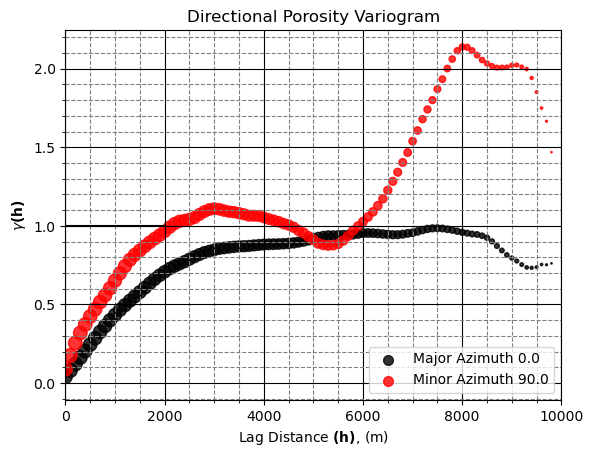

In [34]:
# If the user wants to proceed the generation from a certain point in cases, the variable
# proceed_from_idx could be changed from 1 to anything.
proceed_from_idx = 1
cases = cases[proceed_from_idx-1:]

# Setting correlations and other necessary parameters for data generation
corrs = [0, 0.90, -0.98]
num_of_features = len(corrs)
nx = 100; ny = 100; xsiz = 10.0; ysiz = 10.0; xmn = 5.0; ymn = 5.0; nxdis = 1; nydis = 1
ndmin = 0; ndmax = 1000; radius = 10000; skmean = 0
tmin = -9999; tmax = 9999

# Setting noise percentages and variances
percentages = np.array([0, 10, 20, 30])
noise_vars = (percentages * 100) / (100 - percentages) / 100

# Setting random seed
np.random.seed(73703)

# Initializing the folder creation if the code is run for the first time (no dataset folders)
if not os.path.exists('dataset'):
    os.mkdir('dataset')

if not os.path.exists('dataset/vardump'):
    os.mkdir('dataset/vardump')
        
if not os.path.exists('dataset/vardump/noadhere'):
    os.mkdir('dataset/vardump/noadhere')

# Iterating for each case
for case in cases:
    # Setting the major and minor variogram ranges
    hmaj, hmin = case[0], case[1]
    
    # Building the variogram using GSLIB
    vario = GSLIB.make_variogram(nug=0.0,nst=1,it1=1,cc1=1.0,azi1=0.0,hmaj1=hmaj,hmin1=hmin)
    

    blockPrint() # Disabling printing because SGSIM has a long print output for each simulation
    
    # SGSIM routine, we store the simulations in sims and the resultant dataframe in alpha
    sims, alpha = benchmark_generator(corrs, df_orig, hmaj, hmin, 3, 73703) 
    
    enablePrint() # Re-enabling printing
    
    # The resulting dataframe is for each pixel. We would like to
    # Scale it by 100, so that it represents an area of 10000x10000,
    # Which is more realistic for geoscientific applications
    alpha['x'] = alpha['x'] * 100
    alpha['y'] = alpha['y'] * 100
    
    # Setting the name tag
    name = str(hmaj*10) + '_' + str(hmin*10)
    
    df = alpha.copy() # Default is deep copy
    
    #### Checking if the simulation adheres to variogram
    # This is necessary because sometimes artefacts might happen during the simulation,
    # Resulting in simulations that does not preserve the variogram information,
    # Hence would be erroneous to use in n_eff workflow
    
    plt.figure(figsize=(16,4)) # Creating the figure
    
    # Subroutine to plot each feature
    for i in range(num_of_features):
        plt.subplot(1,num_of_features, i+1)
        blockPrint()
        lags, gamma_x, npps_x = geostats.gam(sims[i],-9999.9,9999.9,100.0,100.0,ixd=1,iyd=0,nlag=100,isill=1)
        lags, gamma_y, npps_y = geostats.gam(sims[i],-9999.9,9999.9,100.0,100.0,ixd=0,iyd=1,nlag=100,isill=1)
        vargplot('Porosity',lags,gamma_y,gamma_x,npps_y,npps_x,vario,azi=0.0,atol=22.5,sill=1.0)
        enablePrint()
    plt.show()
    question = input('hmaj_hmin: ' + name + ' Does it adhere to variogram?(y/n):\t')
    
    # Save the dataset to dataset folder if data adheres to variogram
    if(question=='y'):
        vargplot('Porosity',lags,gamma_y,gamma_x,npps_y,npps_x,vario,azi=0.0,atol=22.5,sill=1.0,save='dataset/vardump/' + name) # Save variogram plot to vardump
        features = list(df.columns[2:])
        for idx, var in enumerate(noise_vars):
            noise_lvl_str = str(percentages[idx])
            for feature in features:
                data = df[feature].values
                noise = np.random.normal(0, var**0.5, data.shape[0])
                df[feature] = StandardScaler().fit_transform((df[feature] + noise).values.reshape(-1, 1))
            if not os.path.exists('dataset/'+ name + '_' + noise_lvl_str):
                os.mkdir('dataset/'+ name + '_' + noise_lvl_str)
            df.to_csv('dataset/'+ name + '_' + noise_lvl_str + '/' + name + '_' + noise_lvl_str +  '.csv', index=False)
    # Save the variogram to 'no adhere' folder if data doesn't adhere to variogram and don't keep the dataset
    else:
        vargplot('Porosity',lags,gamma_y,gamma_x,npps_y,npps_x,vario,azi=0.0,atol=22.5,sill=1.0,save='dataset/vardump/noadhere/' + name) # Save variogram plot to vardump/noadhere
        clear_output()
    clear_output()